# Calcul des coefficients des 5 fonctions de transferts

In [68]:
%load_ext autoreload
%autoreload 2

import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
from scipy import signal as sg
from scipy import integrate
from scipy.interpolate import interpn,interp1d,RegularGridInterpolator, Akima1DInterpolator

import time
from tqdm import notebook
import importlib

import torch
from torch.utils.data import TensorDataset, DataLoader

import tarfile

%matplotlib inline

import copy

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


J'ai modifié pred pour qu'elle puisse fonctionner pour n'importe quel degré de fonction de transfert

In [69]:
from scipy.optimize import minimize
import scipy.signal as sig
from scipy.optimize import least_squares

#b = [2,1]       # numerateur
#a = [1,0.5,1]     # denominateur

#H_1 = sig.lti(b,a)

def pred(x, t_e, entree):
    """
    Gives the response of a LTI system
    - at times t_e 
    - given an imput signal entree
    - given coefficients x
    """
    b = x[:int(len(x)/2)]
    a = x[int(len(x)/2):]
    H_1 = sig.lti(b,a)
    [t_s, sortie, xout] = H_1.output(entree,t_e)
    return sortie

def err(x, t, entree, y):
    """ Computes the squared error between truth and prediction """
    return (pred(x, t, entree) - y)**2

def err_multi(x, times, entrees, outputs):
    """ Computes the squared error between truth and prediction at multiple times """
    error = 0
    for k in range(len(entrees)) :
        error += np.mean(err(x,times[k],entrees[k],outputs[k]))
    return error 

def RMSE(real,prediction):
    """ Computes the mean squared error between truth and prediction """
    rmse = 0
    for k in range(len(real)):
        rmse += (real[k]-prediction[k])**2
    return rmse/len(real)

In [90]:
rep_data = "./data/DataSet_phase1/"
names = ["input"+str(k) for k in range(0,7)]  

columns_titles = ['Time','Input','Output1','Output2','Output3','Output4','Output5']
d = {} # Data
for name in names:
    d[name] = pd.read_csv(rep_data + name + '.csv',sep=',',index_col=False)
d['input0']

,Time,output1,input,output2,output3,output4,output5
0,0.000,-2.464122e-07,0.0,0.500000,0.500000,1.011923,1.009830
1,0.001,-2.464121e-07,0.0,0.500000,0.500000,1.011923,1.009830
2,0.002,-2.464121e-07,0.0,0.500000,0.500000,1.011923,1.009830
3,0.003,-2.464121e-07,0.0,0.500000,0.500000,1.011923,1.009830
4,0.004,-2.464121e-07,0.0,0.500000,0.500000,1.011923,1.009830
...,...,...,...,...,...,...,...
10231,10.231,4.889346e-01,0.0,0.346165,0.636405,0.603184,1.387077
10232,10.232,4.874977e-01,0.0,0.346696,0.635954,0.604425,1.385976
10233,10.233,4.860656e-01,0.0,0.347225,0.635506,0.605663,1.384878
10234,10.234,4.846381e-01,0.0,0.347751,0.635059,0.606896,1.383784


In [91]:
columns_titles = ['Time','Output1','Input','Output2','Output3','Output4','Output5']
#columns_titles = ['Time','Input','Output1','Output2','Output3','Output4','Output5']

for name in names:
    d[name].columns = columns_titles
    d[name] = d[name][['Time','Input','Output1','Output2','Output3','Output4','Output5']]
    

In [92]:
d['input0']

,Time,Input,Output1,Output2,Output3,Output4,Output5
0,0.000,0.0,-2.464122e-07,0.500000,0.500000,1.011923,1.009830
1,0.001,0.0,-2.464121e-07,0.500000,0.500000,1.011923,1.009830
2,0.002,0.0,-2.464121e-07,0.500000,0.500000,1.011923,1.009830
3,0.003,0.0,-2.464121e-07,0.500000,0.500000,1.011923,1.009830
4,0.004,0.0,-2.464121e-07,0.500000,0.500000,1.011923,1.009830
...,...,...,...,...,...,...,...
10231,10.231,0.0,4.889346e-01,0.346165,0.636405,0.603184,1.387077
10232,10.232,0.0,4.874977e-01,0.346696,0.635954,0.604425,1.385976
10233,10.233,0.0,4.860656e-01,0.347225,0.635506,0.605663,1.384878
10234,10.234,0.0,4.846381e-01,0.347751,0.635059,0.606896,1.383784


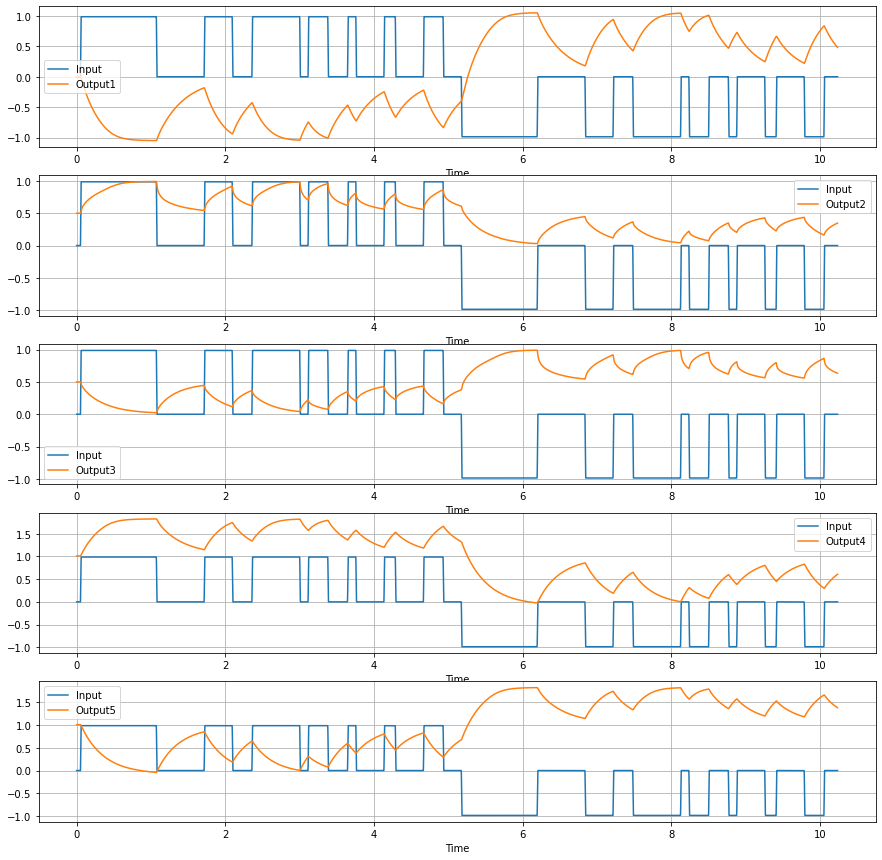

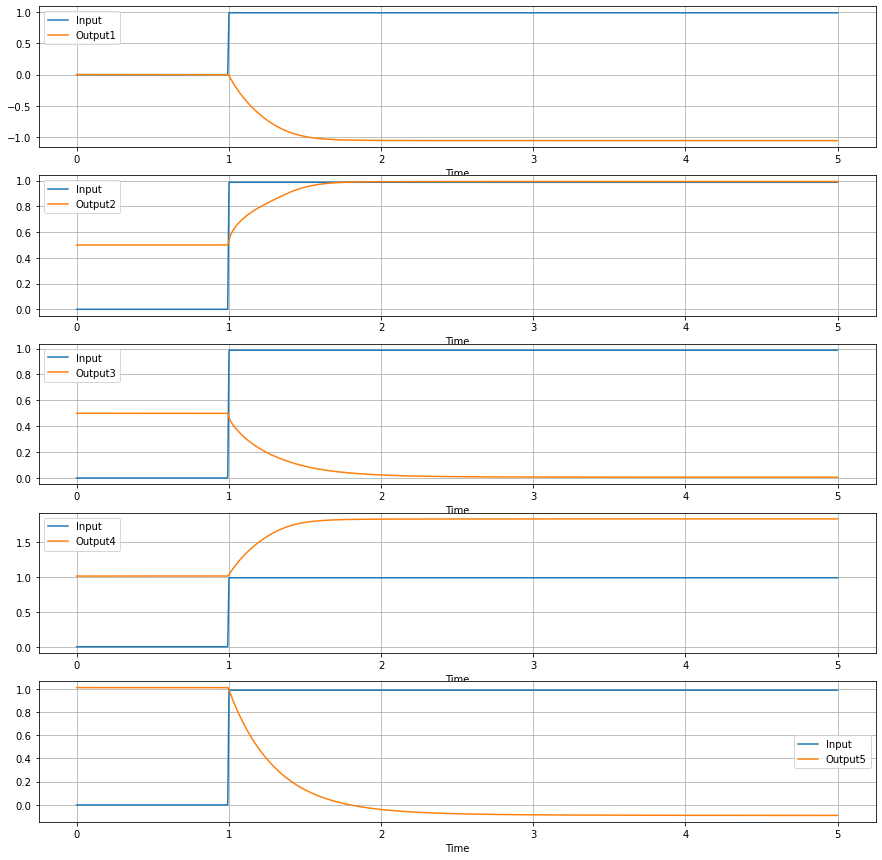

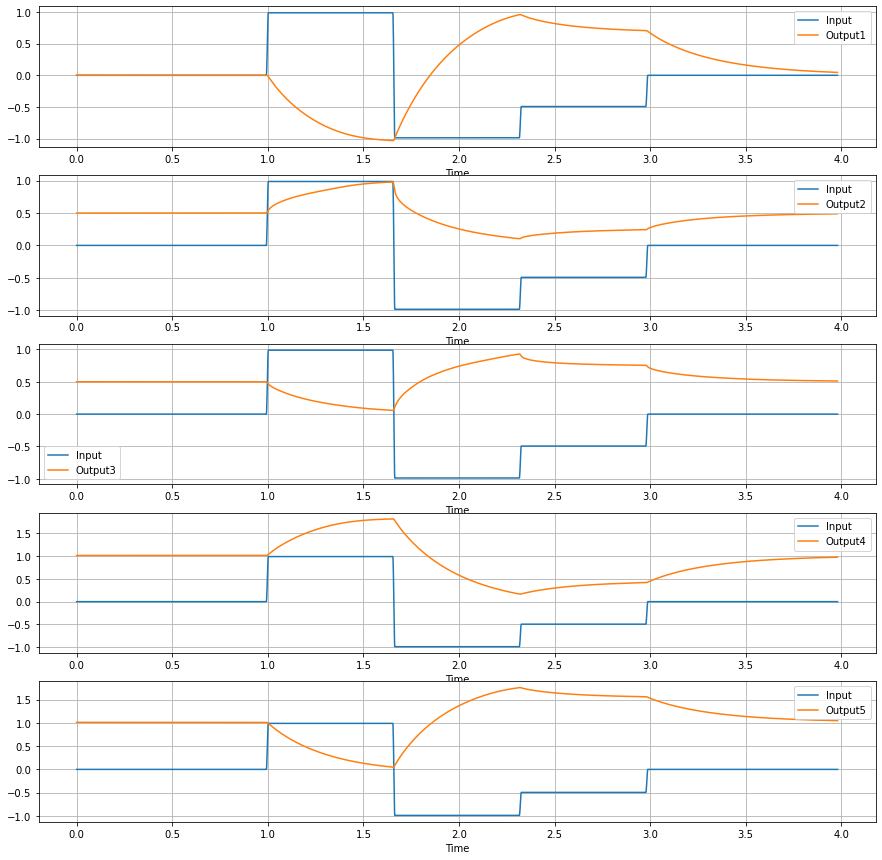

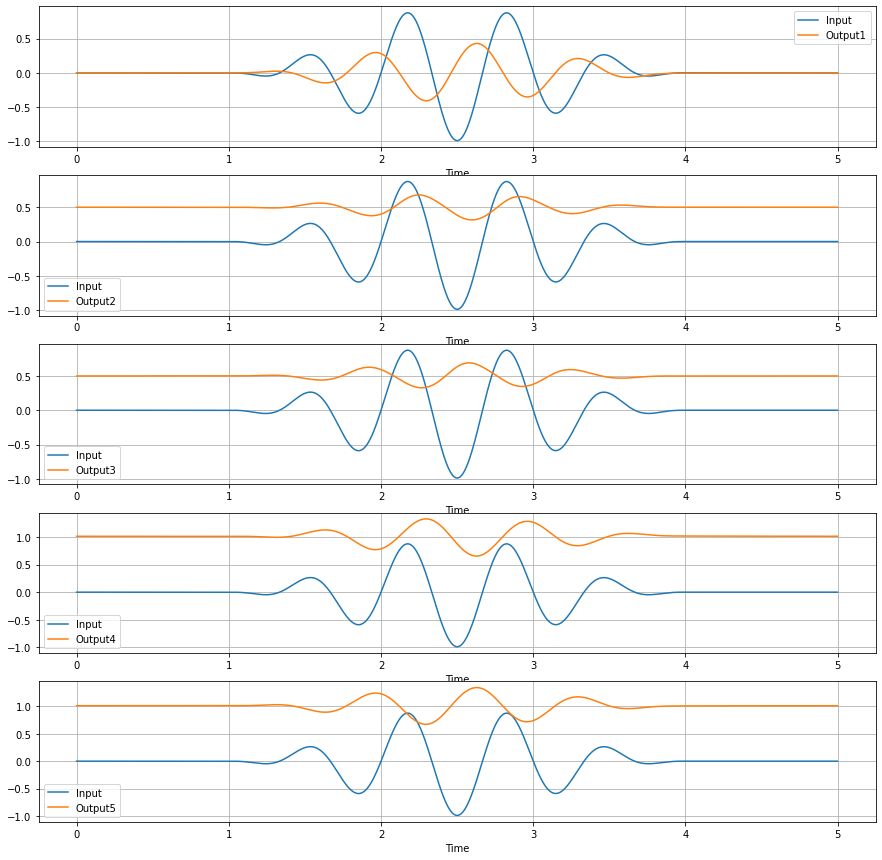

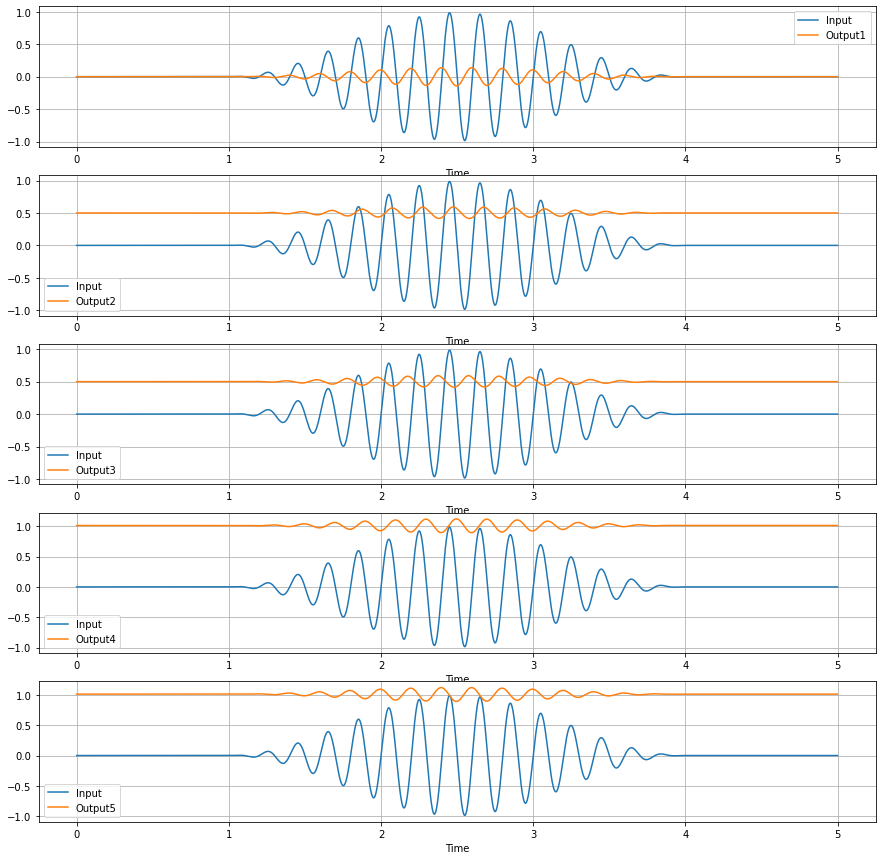

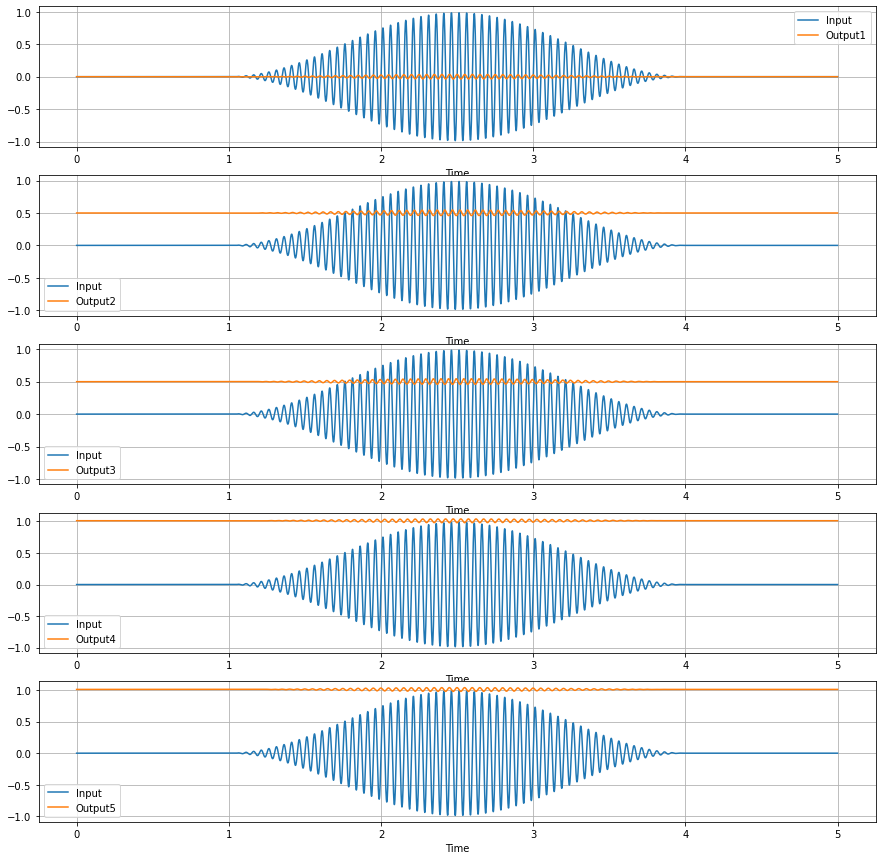

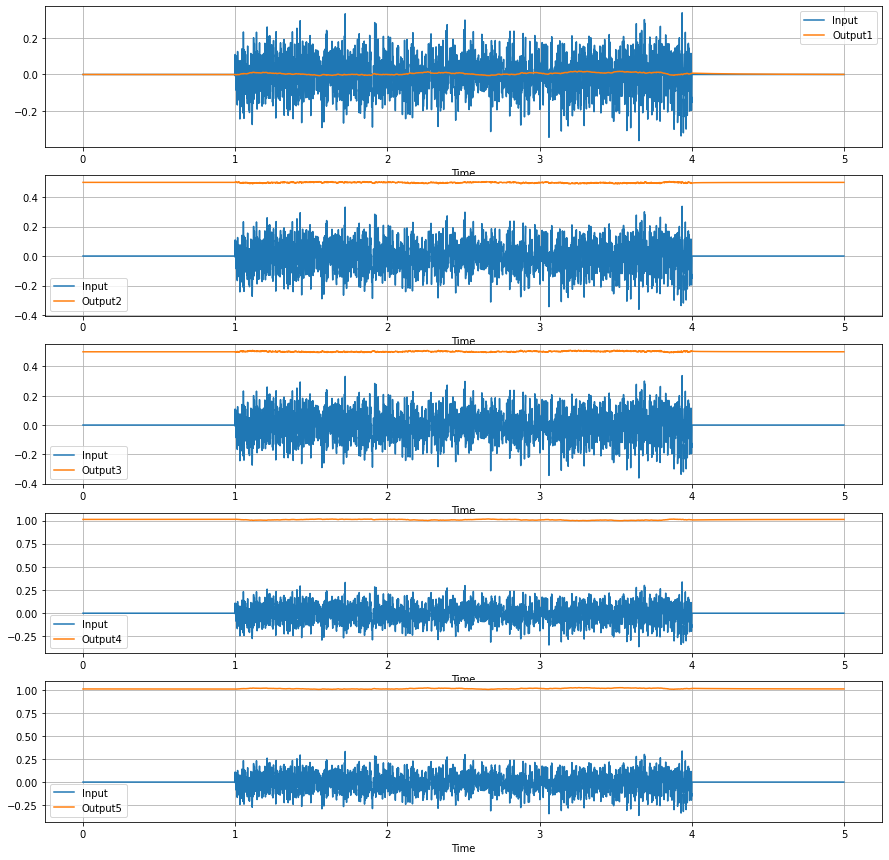

In [93]:
##Tracé des inputs et des outputs

N_input   = 1
N_outputs = 5
N_signals = len(names)

for name in names:
    fig,ax = plt.subplots(N_outputs,1,figsize=(15,15))
    for k in range(N_outputs):
        d[name].plot(ax=ax[k],x='Time',y=[1,k+2],grid='on')

Il est nécessaire de standardiser les Outputs pour utiliser les modules scipy LTI, on supprime l'offset et on normalise à 1 les Output

In [74]:
##Calcul des shrink (positif ou négatif) et des offset de chaque output

Output_names = ['Output1','Output2','Output3','Output4','Output5']
Output_correction = {'Output1':[0,0],'Output2':[0,0],'Output3':[0,0],'Output4':[0,0],'Output5':[0,0]}
for name in Output_names:
    offset = d['input0'][name][1]
    Output_correction[name][0] = offset
    
    shrink = (d['input1'][name][5000]-offset)/d['input1']['Input'][5000]
    Output_correction[name][1] = shrink

In [75]:
###Traitement des output
   
d_corrige = copy.deepcopy(d)
    
for key in d_corrige.keys():
    for name in Output_names:
        d_corrige[key][name] = d[key][name] - Output_correction[name][0] 
        d_corrige[key][name] = 1/Output_correction[name][1]*d_corrige[key][name]

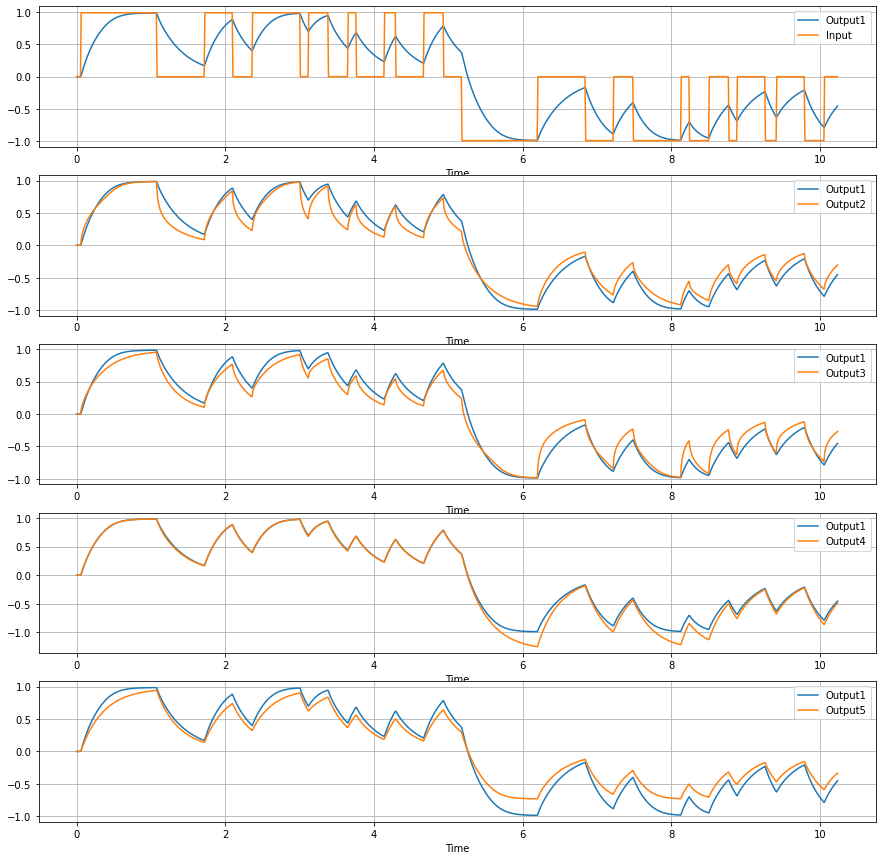

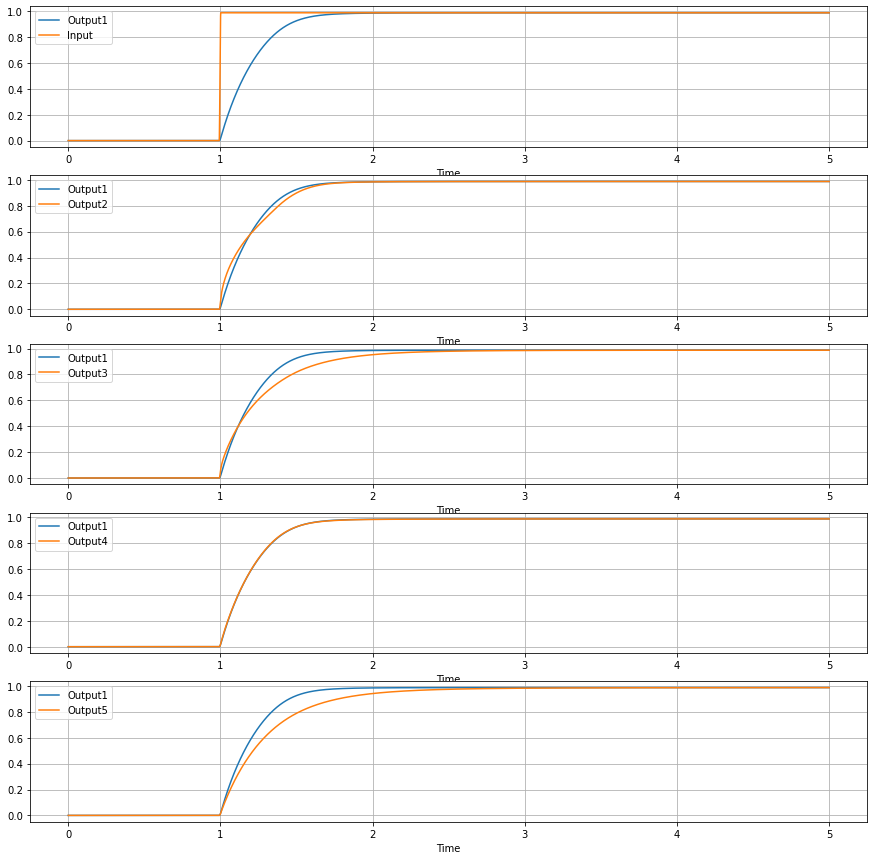

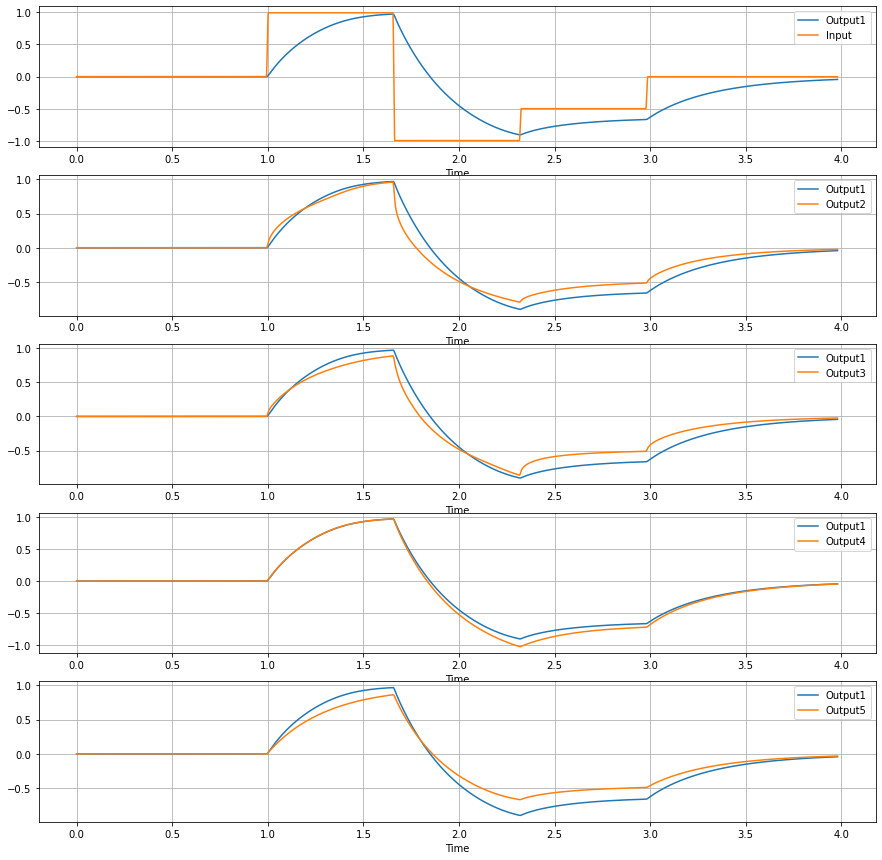

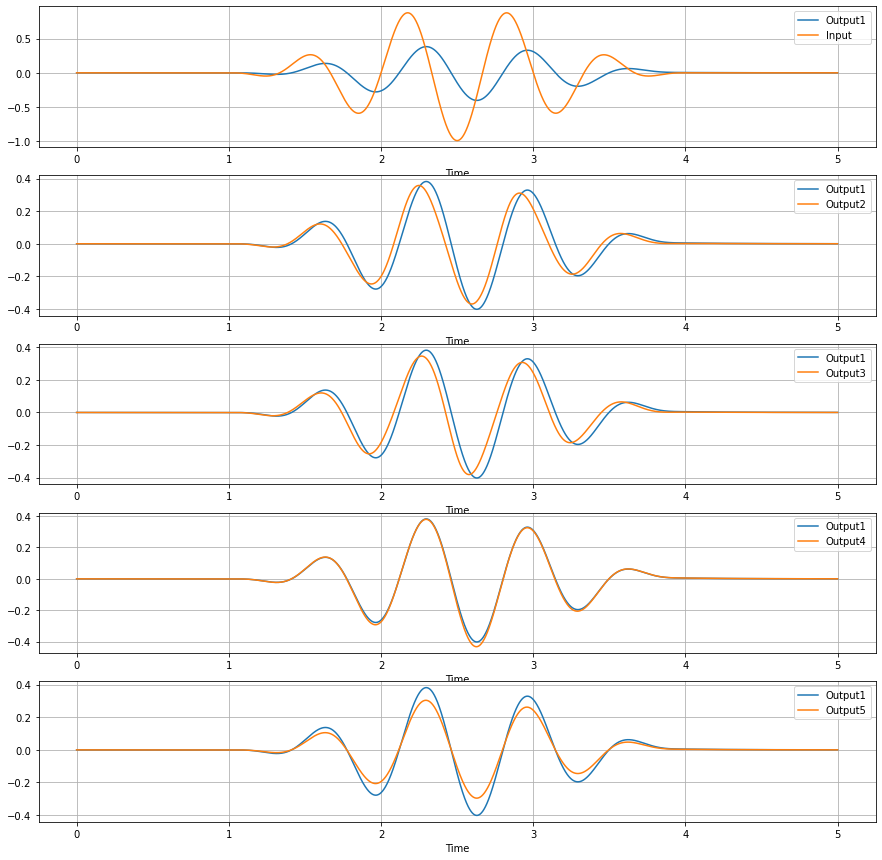

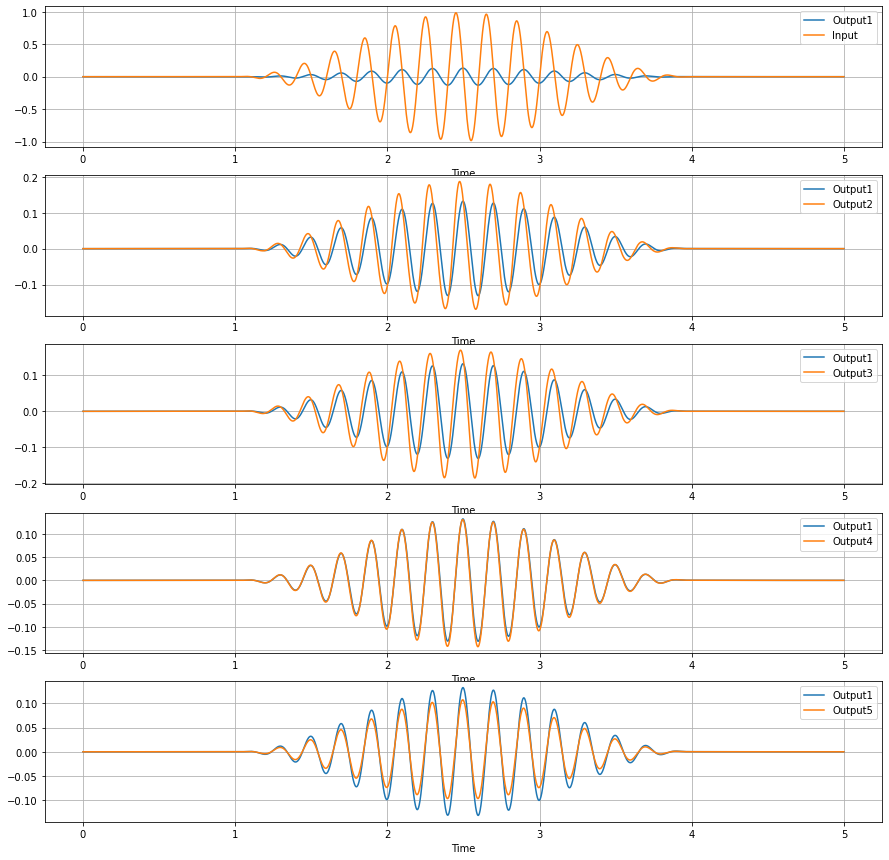

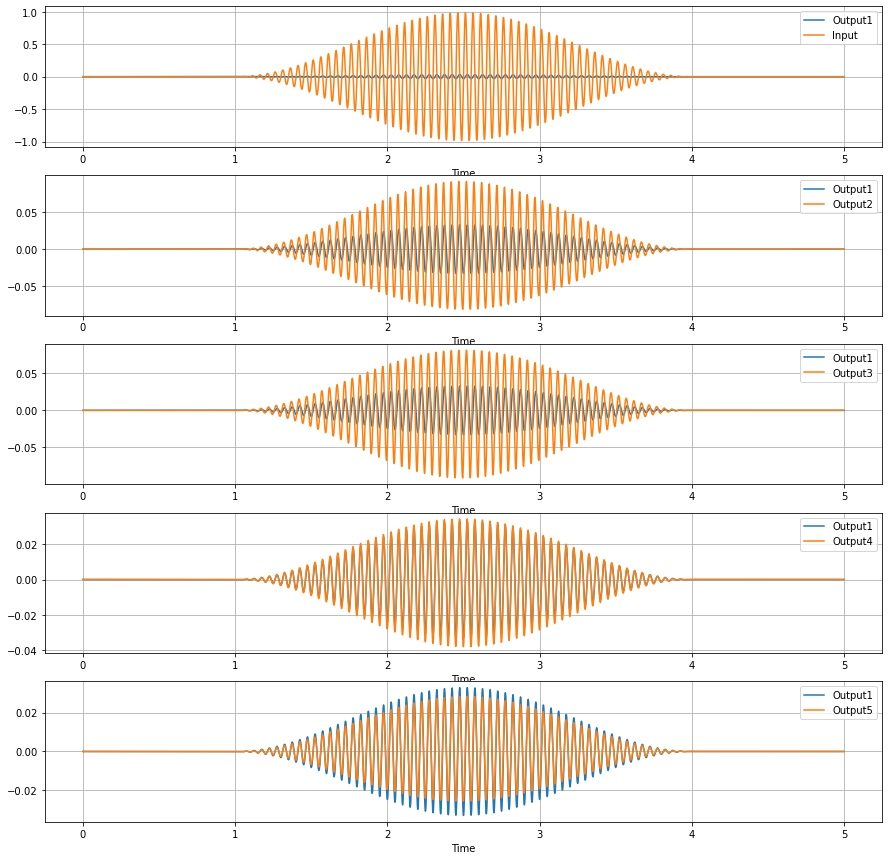

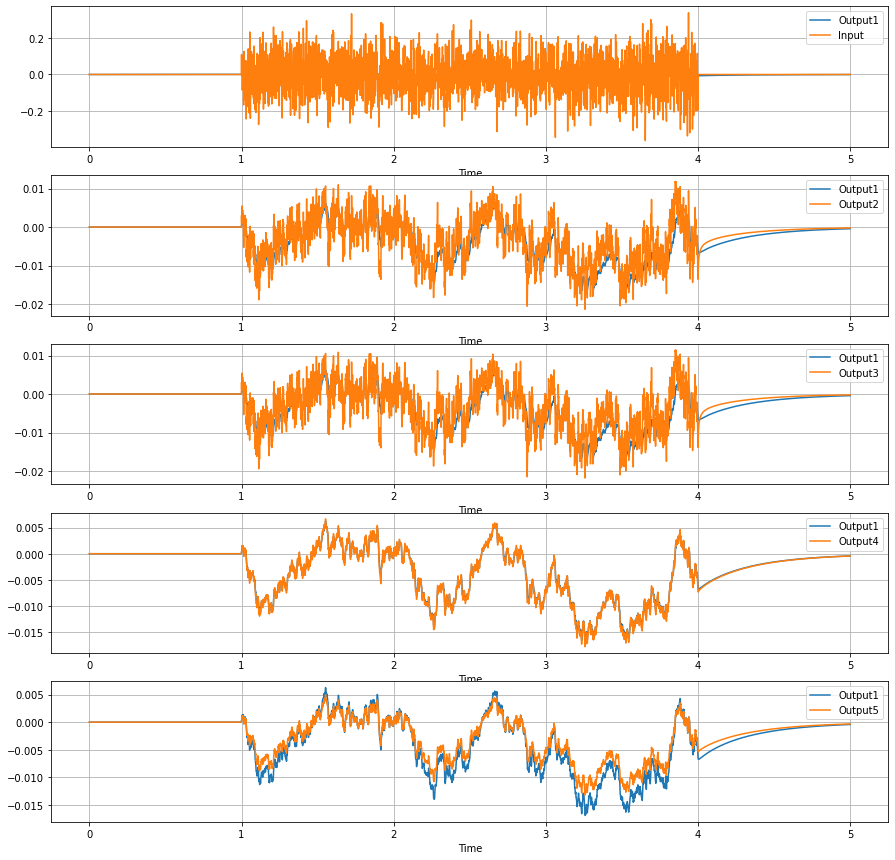

In [76]:
##Tracé des inputs et des Outputs corrigés

N_input   = 1
N_outputs = 5
N_signals = len(names)

for name in names:
    fig,ax = plt.subplots(N_outputs,1,figsize=(15,15))
    for k in range(N_outputs):
        d_corrige[name].plot(ax=ax[k],x='Time',y=[1,k+2],grid='on')

# Stratégie 1 : Calcul des coefficients en minimisant l'erreur d'un seul input

Pour cette stratégie, l'entrainement sur l'input0 est bien plus efficace que les autres. Par ailleurs elle est plus rapide, on peut tester avec des degrés plus élevés pour la fonction de transfert.

In [77]:
##Calcul des coefficient avec un seul input

input_train = "input0"
params_output = {}
Compteur = 0
N_total = len(Output_names)
degre = 5

for name in Output_names:
    
    Time = d[input_train]['Time']
    Input = d[input_train]['Input']
    Output = d_corrige[input_train][name]
    
    ##Calcul des paramètre à un degré donné
    x0 = np.ones(2*degre)
    x = np.arange(1,2*degre+1)

    res = least_squares(err, x0, bounds=(-3, 3), args=(Time, Input, Output), verbose=0, ftol=1e-15, gtol=1e-15, xtol = 1e-15)
    x = res.x
    
    Compteur += 1
    print("Avancement : " + str(round(Compteur/N_total*100)) + "%")

    params_output[name] = x

Avancement : 20%
Avancement : 40%
Avancement : 60%
Avancement : 80%
Avancement : 100%


In [78]:
##Calcul des sorties, en "inversant" la correction effectuée plus tôt

Sorties = copy.deepcopy(d)

for key in d.keys():
    for name in Output_names:
        Time = d[key]['Time']
        Input = d[key]['Input']
        Output = d[key][name]
        
        x = params_output[name]
        sortie = pred(x,Time,Input)*Output_correction[name][1]+Output_correction[name][0]  ##On inverse la correction faite sur les outputs
        Sorties[key][name+"_approx"] = sortie
    
    Sorties[key] = pd.DataFrame(Sorties[key])

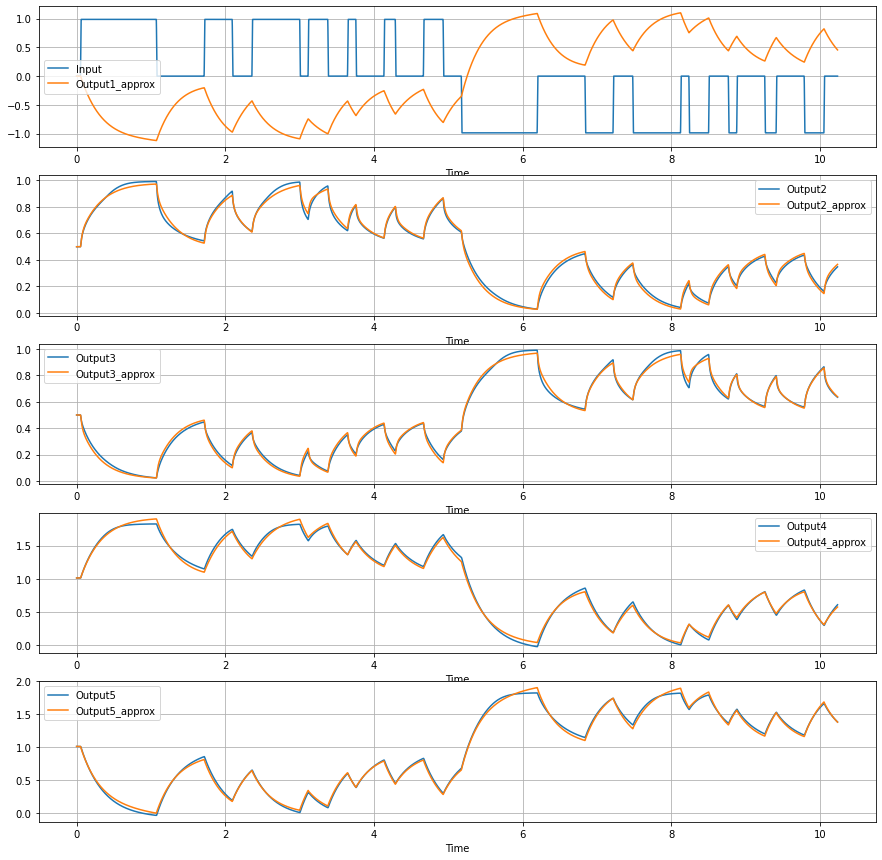

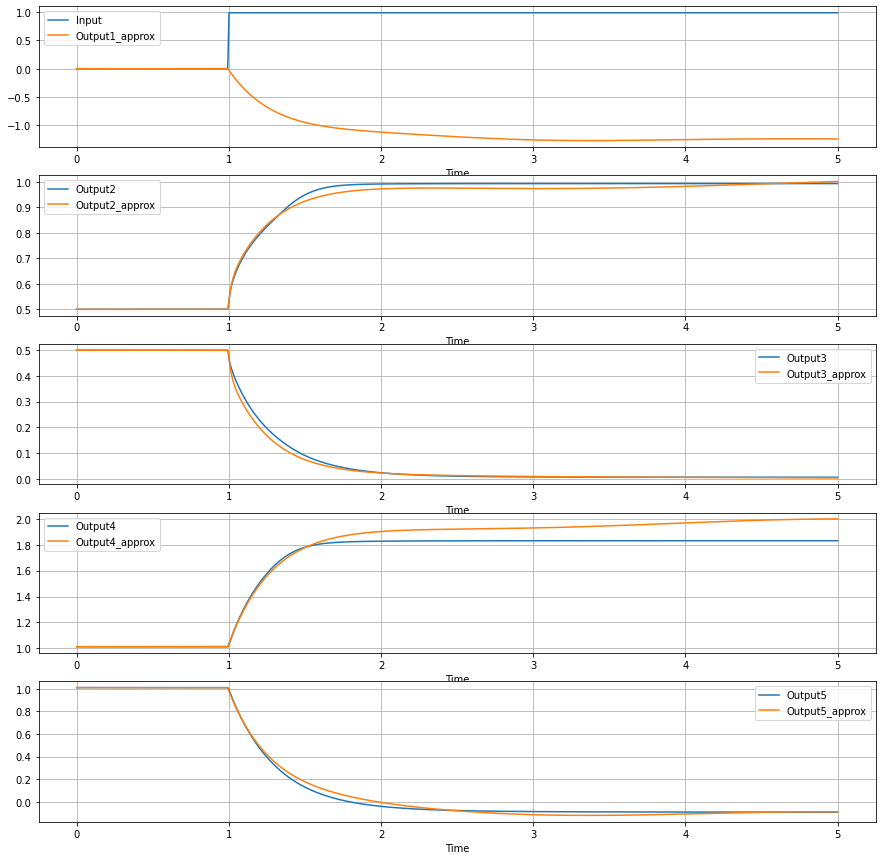

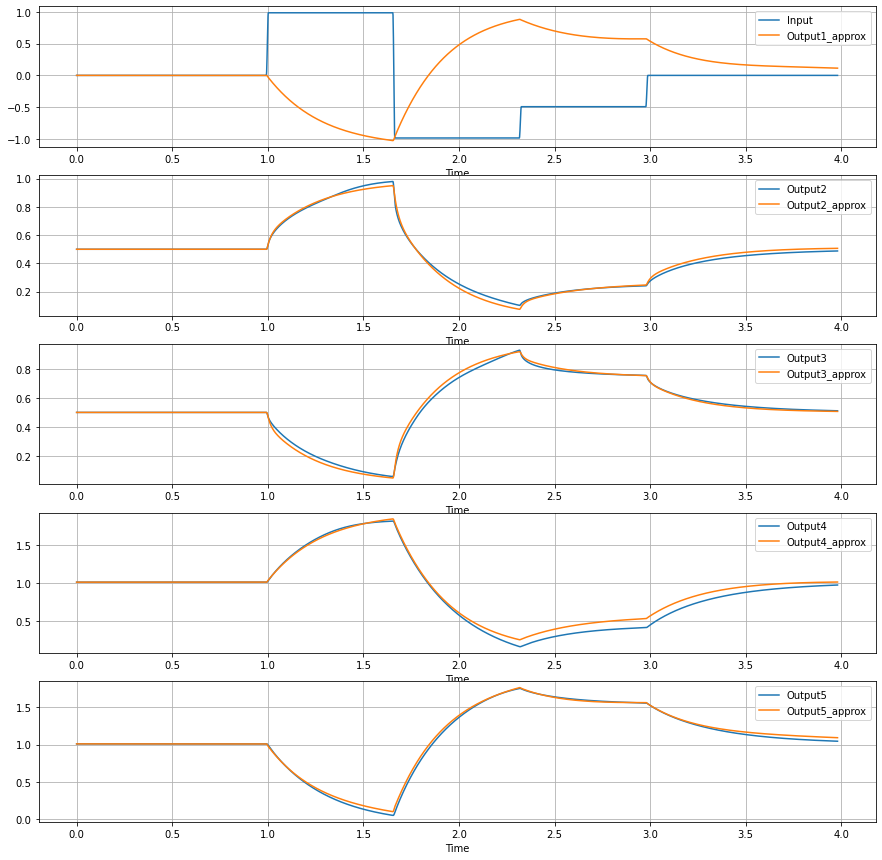

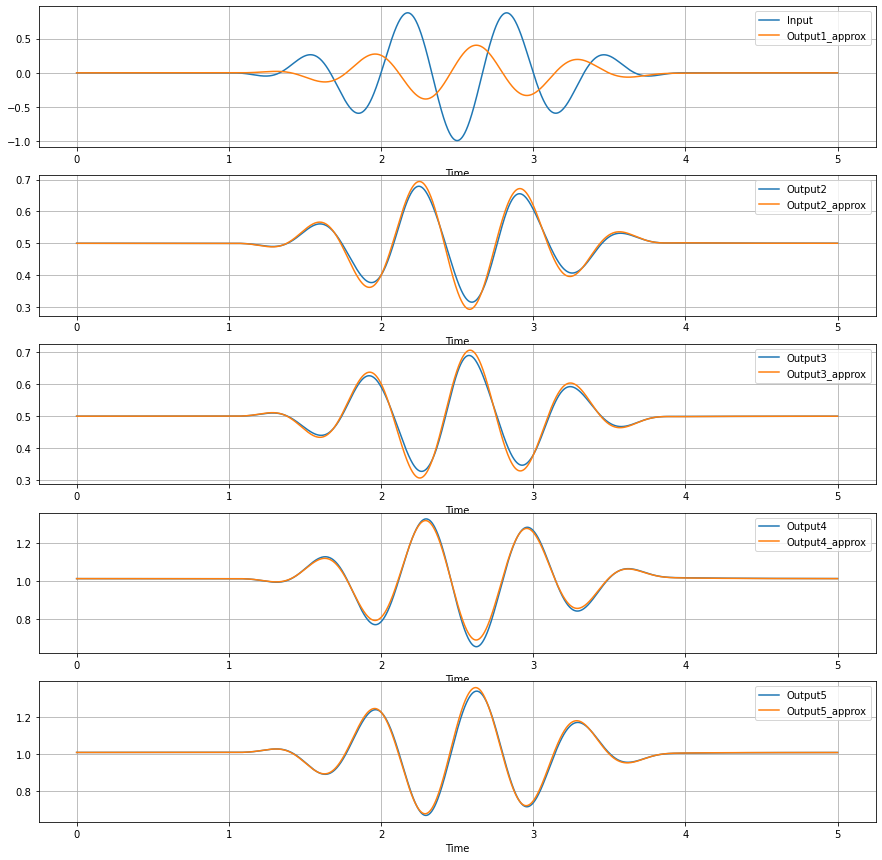

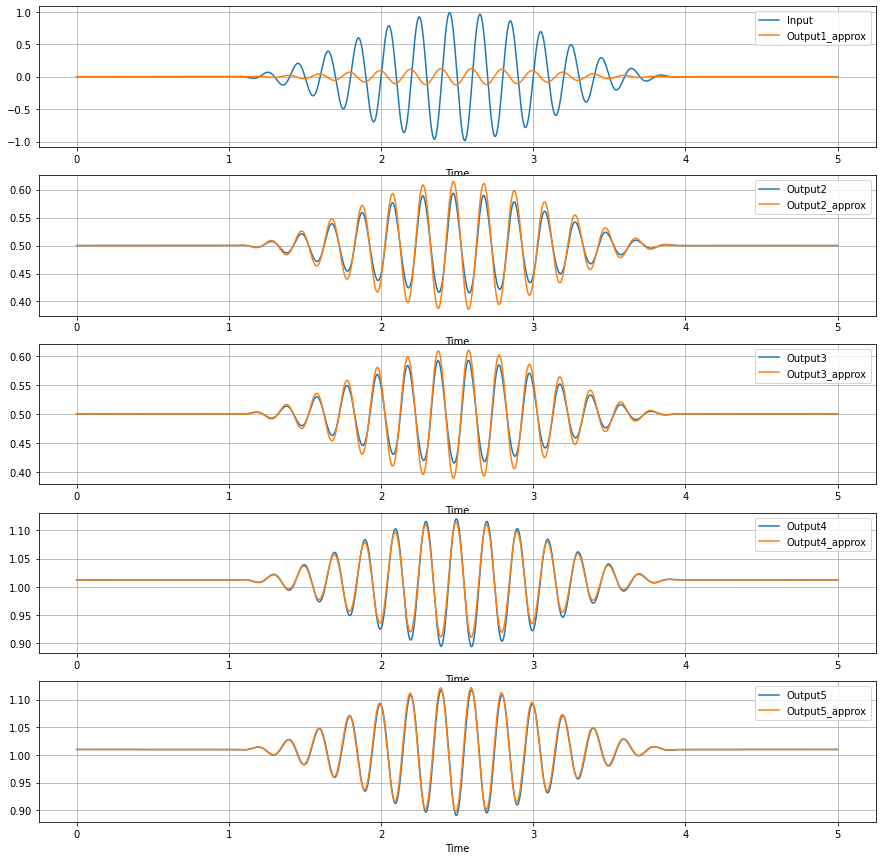

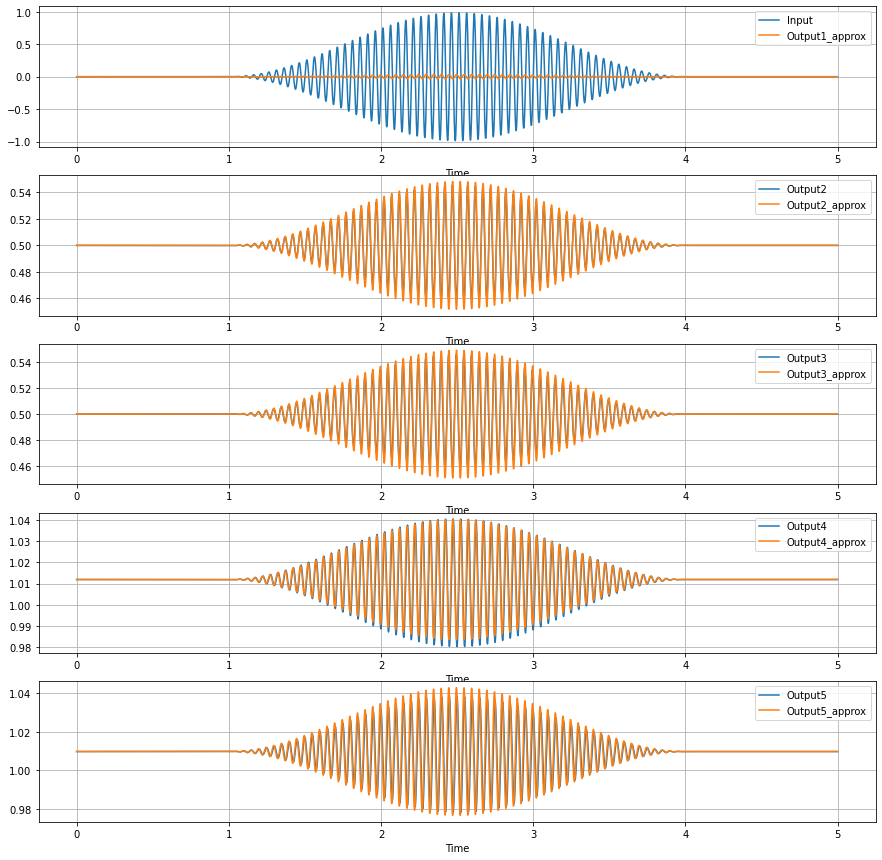

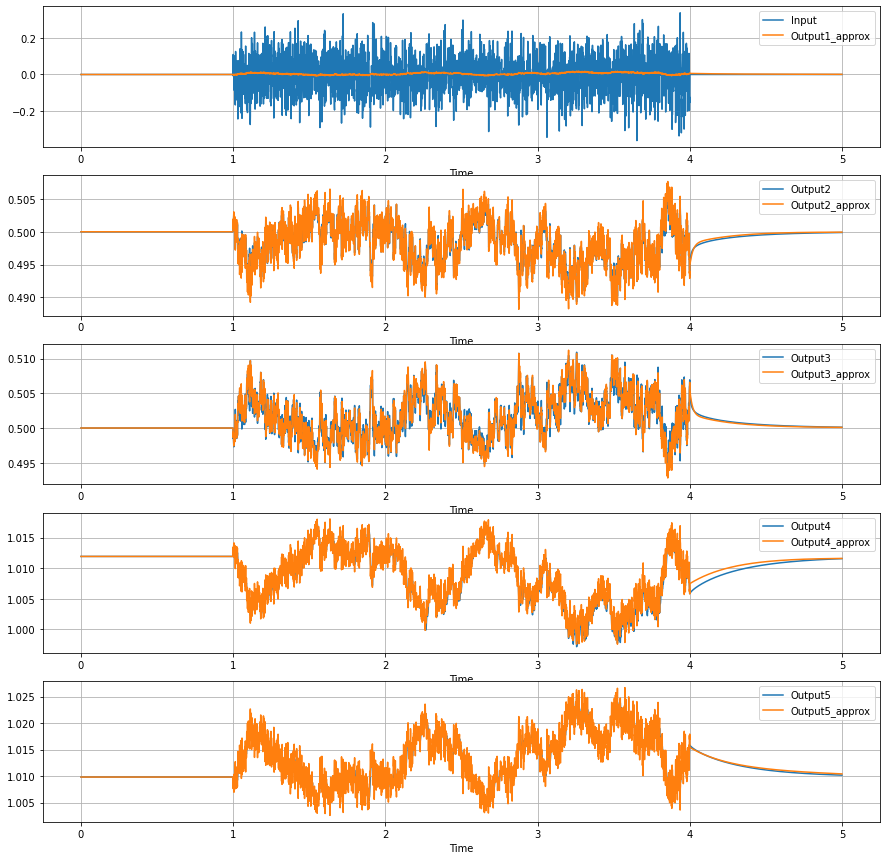

In [79]:
##Tracé des outputs et des outputs approximés

N_input   = 1
N_outputs = 5
N_signals = len(names)

for name in names:
    fig,ax = plt.subplots(N_outputs,1,figsize=(15,15))
    for k in range(N_outputs):
        Sorties[name].plot(ax=ax[k],x='Time',y=[k+2,k+2+N_outputs],grid='on')

In [80]:
###RMSE pour chacun des signaux

N_input   = 1
N_outputs = 5
N_signals = len(names)
mean_rmse_test = 0
mean_rmse_train = 0 
mean_rmse = 0

for name in names:
    for k in range(N_outputs):
        rmse = RMSE(Sorties[name][Output_names[k]],Sorties[name][Output_names[k]+"_approx"])
        mean_rmse_train += rmse*(name in inputs_train)/(5*len(inputs_train))
        mean_rmse_test += rmse*(name in inputs_test)/(5*len(inputs_test))
        mean_rmse += rmse/(5*len(names))
        print("RMSE pour " + str(name) +" et " + Output_names[k] + " : " + str(rmse))
        print("Input d'entrainement : " + str(name == input_train))
        print("-----------------")
        
print("RMSE moyenne sur echantillon train : " + str(mean_rmse_train) )
print("RMSE moyenne sur echantillon test : " + str(mean_rmse_test) )
print("RMSE moyenne : " + str(mean_rmse) )

NameError: name 'inputs_train' is not defined

# Stratégie 2 : Calcul des coefficients en minimisant l'erreur moyenne des inputs d'entrainement

Entrainement plus couteux en temps mais de meilleurs résultats à degré égal avec la stratégie 1.

In [ ]:
inputs_train = ['input0','input1','input3','input5']
inputs_test = ['input2','input4','input6']

entrees_train = [d[key]['Input'] for key in inputs_train]
times_train = [d[key]['Time'] for key in inputs_train]
params_output_2 = {}
degre = 3
N_total = len(Output_names)
Compteur = 0

for name in Output_names:
    outputs = [d_corrige[key][name] for key in inputs_train]
    
    x0 = np.ones(2*degre)
    x = np.arange(1,2*degre+1)

    res = least_squares(err_multi, x0, bounds=(-3, 3), args=(times_train,entrees_train,outputs), verbose=1, ftol=1e-15, gtol=1e-15, xtol = 1e-15, max_nfev = 50)
    x = res.x

    Compteur += 1
    print("Avancement : " + str(round(Compteur/N_total*100)) +"%")
        
    params_output_2[name] = x

In [ ]:
##Calcul des sorties, en "inversant" la correction effectuée plus tôt

Sorties_v2 = copy.deepcopy(d)

for key in d.keys():
    for name in Output_names:
        Time = d[key]['Time']
        Input = d[key]['Input']
        Output = d[key][name]
        
        x = params_output_2[name]
        sortie = pred(x,Time,Input)*Output_correction[name][1]+Output_correction[name][0]  ##On inverse la correction faite sur les outputs
        Sorties_v2[key][name+"_approx"] = sortie
    
    Sorties_v2[key] = pd.DataFrame(Sorties_v2[key])

In [ ]:
##Tracé des outputs et des outputs approximés sur l'échantillon d'entrainement

N_input   = 1
N_outputs = 5
N_signals = len(names)

for name in inputs_train:
    fig,ax = plt.subplots(N_outputs,1,figsize=(15,15))
    for k in range(N_outputs):
        Sorties_v2[name].plot(ax=ax[k],x='Time',y=[k+2,k+2+N_outputs],grid='on')

In [ ]:
##Tracé des outputs et des outputs approximés sur l'échantillon de test

N_input   = 1
N_outputs = 5
N_signals = len(names)

for name in inputs_test:
    fig,ax = plt.subplots(N_outputs,1,figsize=(15,15))
    for k in range(N_outputs):
        Sorties_v2[name].plot(ax=ax[k],x='Time',y=[k+2,k+2+N_outputs],grid='on')

In [ ]:
###RMSE pour chacun des signaux

N_input   = 1
N_outputs = 5
N_signals = len(names)
mean_rmse_test = 0
mean_rmse_train = 0 
mean_rmse = 0

for name in names:
    for k in range(N_outputs):
        rmse = RMSE(Sorties_v2[name][Output_names[k]],Sorties_v2[name][Output_names[k]+"_approx"])
        mean_rmse_train += rmse*(name in inputs_train)/(5*len(inputs_train))
        mean_rmse_test += rmse*(name in inputs_test)/(5*len(inputs_test))
        mean_rmse += rmse/(5*len(names))
        print("RMSE pour " + str(name) +" et " + Output_names[k] + " : " + str(rmse))
        print("Input d'entrainement : " + str(name in inputs_train))
        print("Amelioration : " + str(rmse<RMSE(Sorties[name][Output_names[k]],Sorties[name][Output_names[k]+"_approx"])))
        print("-----------------")

        
print("RMSE moyenne sur echantillon train : " + str(mean_rmse_train) )
print("RMSE moyenne sur echantillon test : " + str(mean_rmse_test) )
print("RMSE moyenne : " + str(mean_rmse) )

# Stratégie 3 : Agrégation des coefficients selon la similitude entre les inputs

Ici on aura des coefficients pour chacun des inputs pour une fonction de transfert donnée (un indice d'output), donc $N_{outputs}\times N_{inputs}$.

In [ ]:
from sklearn.metrics import mean_absolute_error

def similitude(signal1,signal2):
    length = min([len(signal1),len(signal2)])
    return RMSE(signal1[:length-1],signal2[:length-1])

def similitude_variations(time,signal1,signal2):
    length = len(time)
    derivative_signal1 = []
    derivative_signal2 = []
    time_step = time[1]-time[0]
    
    for k in range(length-2):
        derivative_signal1.append((signal1[k+1]-signal1[k])/time_step)
        derivative_signal2.append((signal2[k+1]-signal2[k])/time_step) 
    
    return RMSE(derivative_signal1,derivative_signal2)

def similitude_variations2(time,signal1,signal2):
    length = len(time)
    derivative_signal1 = []
    derivative_signal2 = []
    time_step = time[1]-time[0]
    
    for k in range(1,length-2):
        derivative_signal1.append((signal1[k+1]-2*signal1[k]+signal1[k+2])/time_step**2)
        derivative_signal2.append((signal2[k+1]-2*signal1[k]+signal1[k+2])/time_step**2) 
    
    return RMSE(derivative_signal1,derivative_signal2)

def similitude_MAE(signal1,signal2) :
    length = min([len(signal1),len(signal2)])
    return mean_absolute_error(signal1[:length-1],signal2[:length-1])

def similitude_moyenne(time,signal1,signal2):
    sim1 = similitude(signal1,signal2)
    sim2 = similitude_variations(time,signal1,signal2)
    sim3 = similitude_variations2(time,signal1,signal2)
    return np.mean([sim1,sim2,sim3])

In [ ]:
##Coefficients pour chacun des inputs du set d'entrainement

inputs_train = ['input0','input1','input3','input5']
inputs_test = ['input2','input4','input6']

params_output_3 = {}
for name in Output_names : 
    params_output_3[name] = {}
    
degre = 3
N_total = len(Output_names)*len(inputs_train)
Compteur = 0

for name in Output_names:
    for key in inputs_train :
        time = d[key]['Time']
        entree = d[key]['Input']
        output = d_corrige[key][name]

        x0 = np.ones(2*degre)
        x = np.arange(1,2*degre+1)

        res = least_squares(err, x0, bounds=(-3, 3), args=(time,entree,output), verbose=1, ftol=1e-15, gtol=1e-15, xtol = 1e-15)
        x = res.x

        Compteur += 1
        print("Avancement : " + str(round(Compteur/N_total*100)) +"%")

        params_output_3[name][key] = x

    params_output_3[name] = pd.DataFrame(params_output_3[name])

In [ ]:
###Calcul des coeffs pour les input du set de test

for name in Output_names :
    for key in inputs_test :
        similitudes_dic = {}
        for key_train in inputs_train:
            time1 = d[key]['Time']
            time2 = d[key_train]['Time']
            time = 0
            if len(time1) > len(time2) : time = time2
            else : time = time1
            similitudes_dic[key_train] = similitude_moyenne(time,d[key]['Input'],d[key_train]['Input'])

        somme = sum(list(similitudes_dic.values()))
        coeffs = np.zeros(2*degre)
        for key_train in inputs_train:
            coeffs = coeffs + params_output_3[name][key_train]*similitudes_dic[key_train]/somme
        params_output_3[name][key] = coeffs
    params_output_3[name] = pd.DataFrame(params_output_3[name]) 

In [ ]:
##Calcul des sorties, en "inversant" la correction effectuée plus tôt

Sorties_v3 = copy.deepcopy(d)

for key in d.keys():
    for name in Output_names:
        Time = d[key]['Time']
        Input = d[key]['Input']
        Output = d[key][name]
        
        x = params_output_3[name][key]
        sortie = pred(x,Time,Input)*Output_correction[name][1]+Output_correction[name][0]  ##On inverse la correction faite sur les outputs
        Sorties_v3[key][name+"_approx"] = sortie
    
    Sorties_v3[key] = pd.DataFrame(Sorties_v3[key])

In [ ]:
##Tracé des outputs et des outputs approximés sur l'échantillon de test

N_input   = 1
N_outputs = 5
N_signals = len(names)

for name in inputs_test:
    fig,ax = plt.subplots(N_outputs,1,figsize=(15,15))
    for k in range(N_outputs):
        Sorties_v3[name].plot(ax=ax[k],x='Time',y=[k+2,k+2+N_outputs],grid='on')

In [ ]:
###RMSE pour les signaux de test

N_input   = 1
N_outputs = 5
N_signals = len(names)
mean_rmse_test = 0


for name in inputs_test:
    for k in range(N_outputs):
        rmse = RMSE(Sorties_v3[name][Output_names[k]],Sorties_v3[name][Output_names[k]+"_approx"])
        mean_rmse_test += rmse*(name in inputs_test)/(5*len(inputs_test))
        print("RMSE pour " + str(name) +" et " + Output_names[k] + " : " + str(rmse))
        print("Amelioration : " + str(rmse<RMSE(Sorties_v2[name][Output_names[k]],Sorties_v2[name][Output_names[k]+"_approx"])))
        print("-----------------")

print("RMSE moyenne sur echantillon test : " + str(mean_rmse_test) )